In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve

In [2]:
def get_embed_df():
    df = pd.read_csv('data/embed-non-negative.csv', low_memory=False)
    # df = pd.read_csv("/vol/biomedic3/mb121/tech-demo/code_for_demo/joined_simple.csv", low_memory=False)
    df['image_id'] = [img_path.split('/')[-1] for img_path in df.image_path.values]
    # print(df.shape)
    
    return df

In [10]:
real_model_path = 'final_models_2/real_only_resnet50_bs64_lr0.0001_epochs10'
cf_and_real_model_path = 'final_models_2/cf_and_real_resnet50_bs256_lr0.0005_epochs10'
    
def get_df_prd_emb(model_path, same_class=False):
    pred = 'predictions_proportional.csv' if same_class else 'predictions.csv'
    df_prd = pd.read_csv(os.path.join(model_path, pred))
    # df_prd = pd.read_csv(os.path.join(model_path, 'vindr_test.csv'))
    
    df_emb = pd.read_csv(os.path.join(model_path, 'embeddings.csv'))
    
    return df_prd, df_emb

In [4]:
modelname_group_map = {
    "Selenia Dimensions": "Selenia Dimensions",
    "Senographe Essential VERSION ADS_53.40": "Senographe Essential",
    "Senographe Essential VERSION ADS_54.10": "Senographe Essential",
    "Senograph 2000D ADS_17.4.5": "Senograph 2000D",
    "Senograph 2000D ADS_17.5": "Senograph 2000D",
    "Lorad Selenia": "Lorad Selenia",
    "Clearview CSm": "Clearview CSm",
    "Senographe Pristina": "Senographe Pristina",
}

def get_df_combined(df, df_prd, df_emb):
    df_combined = df_emb.merge(df_prd, on='image_id')
    df_combined['base_image_id'] = df_combined['image_id'].apply(lambda x: x.split('/')[0])

    pd.set_option('display.max_colwidth', None)

    df = df_combined.merge(df, left_on='base_image_id', right_on='image_id')
    
    # grouping together scanner name
    df['scanner_type'] = df['ManufacturerModelName'].map(modelname_group_map)
    
    # adding a prediction and correct columns
    df['prediction'] = df[['class_0', 'class_1']].idxmax(axis=1).apply(lambda x: int(x[-1]))
    df['density_binary'] = df['density'].apply(lambda x: 0 if x in ['A', 'B'] else 1)
    df['correct'] = (df['prediction'] == df['density_binary']).astype(int)
    
    bins = [30, 40, 50, 60, 70, 80, 90]
    labels = ['30-39', '40-49', 
            '50-59', '60-69', '70-79', '80-89']
    df['age_group'] = pd.cut(df['age_at_study'], bins=bins, labels=labels)
    df['age_group'] = pd.Categorical(df['age_group'], categories=labels, ordered=True)
        
    return df

In [5]:
from scipy.stats import norm

def sensitivity_at_fixed_specificity(y_true, y_prob, target_specificity=0.9):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    specificity = 1 - fpr
    
    # Find thresholds where specificity >= target_specificity
    valid_idxs = np.where(specificity >= target_specificity)[0]
    
    if len(valid_idxs) == 0:
        # No threshold satisfies the target specificity — return None or np.nan
        return np.nan, np.nan
    
    # Pick threshold with highest sensitivity
    idx = valid_idxs[-1]  # last index where specificity >= target_specificity
    
    sensitivity = tpr[idx]
    threshold = thresholds[idx]
    
    return sensitivity, threshold

def get_subgroup_sensitivities_at_fixed_specificity(model_path, attribute, target_specificity=0.9, same_class=False):
    df = get_embed_df()
    df_prd, df_emb = get_df_prd_emb(model_path, same_class=same_class)
    df = get_df_combined(df, df_prd, df_emb)
    
    Z = norm.ppf(0.975)  # 95% CI
    
    results = []
    
    for a in df[attribute].dropna().unique():
        subgroup = df[df[attribute] == a]
        
        y_true = subgroup['target'].values
        y_score = subgroup['class_1'].values
        
        sensitivity, threshold = sensitivity_at_fixed_specificity(y_true, y_score, target_specificity=target_specificity)
        
        # Compute variance and CI
        n_pos = np.sum(y_true == 1)
        if n_pos > 0 and not np.isnan(sensitivity):
            var_sens = sensitivity * (1 - sensitivity) / n_pos
            se_sens = np.sqrt(var_sens)
            ci_lower = sensitivity - Z * se_sens
            ci_upper = sensitivity + Z * se_sens
            # Clip to [0,1]
            ci_lower = max(0, ci_lower)
            ci_upper = min(1, ci_upper)
        else:
            ci_lower, ci_upper = np.nan, np.nan
        
        results.append({
            attribute: a,
            'sensitivity_at_90_spec': sensitivity,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'threshold': threshold,
            'n_samples': len(subgroup),
            'n_positives': n_pos
        })
        
    results_df = pd.DataFrame(results)
        
    # print(f"\n=== Subgroup analysis for {attribute} ===")
    # print(results_df.to_string(index=False))
        
    return results_df

In [6]:
import glob
import os 
import pandas as pd

In [23]:
def run_subgroup_analysis_across_models(base_folder, attribute, target_specificity=0.9):

    model_folders = glob.glob(os.path.join(base_folder, '*/'))  # get all subfolders
    print(f"Found {len(model_folders)} model folders.")

    real_only_models = [folder for folder in model_folders if os.path.basename(os.path.normpath(folder)).startswith('real_only')]
    cf_and_real_models = [folder for folder in model_folders if os.path.basename(os.path.normpath(folder)).startswith('cf_and_real')]

    print(f"\nFound {len(real_only_models)} real_only models.")
    print(f"Found {len(cf_and_real_models)} cf_and_real models.\n")

    # Loop over real_only models
    list_real_results = []
    for model_path in real_only_models:
        print(f"Processing real_only model: {model_path}")
        df_result = get_subgroup_sensitivities_at_fixed_specificity(model_path, attribute, target_specificity)
        df_result['model_type'] = 'real_only'
        list_real_results.append(df_result)

    # Loop over cf_and_real models
    list_cf_results = []
    for model_path in cf_and_real_models:
        print(f"Processing cf_and_real model: {model_path}")
        df_result = get_subgroup_sensitivities_at_fixed_specificity(model_path, attribute, target_specificity)
        df_result['model_type'] = 'cf_and_real'
        list_cf_results.append(df_result)

    # Aggregate results
    df_real_all = pd.concat(list_real_results)
    df_cf_all = pd.concat(list_cf_results)

    # Group and compute mean and std
    df_real_summary = df_real_all.groupby(attribute)['sensitivity_at_90_spec'].agg(['mean', 'std']).reset_index()
    df_cf_summary = df_cf_all.groupby(attribute)['sensitivity_at_90_spec'].agg(['mean', 'std']).reset_index()

    # Merge
    comparison_df = df_real_summary.merge(df_cf_summary, on=attribute, suffixes=('_real', '_cf_and_real'))

    # Compute delta
    comparison_df['delta_sensitivity'] = comparison_df['mean_cf_and_real'] - comparison_df['mean_real']
    comparison_df['change'] = comparison_df['delta_sensitivity'].apply(lambda x: 'increase' if x > 0 else ('drop' if x < 0 else 'no change'))

    # Print result
    print(f"\n=== Subgroup comparison for attribute '{attribute}' ===")
    print(comparison_df.to_string(index=False))

    # Return comparison_df in case you want to plot or save
    return comparison_df

In [22]:
from scipy.stats import mannwhitneyu

def run_subgroup_mann_whitney_u_across_models(base_folder, attribute, target_specificity=0.9):

    model_folders = glob.glob(os.path.join(base_folder, '*/'))  # get all subfolders
    print(f"Found {len(model_folders)} model folders.")

    real_only_models = [folder for folder in model_folders if os.path.basename(os.path.normpath(folder)).startswith('real_only')]
    cf_and_real_models = [folder for folder in model_folders if os.path.basename(os.path.normpath(folder)).startswith('cf_and_real')]

    print(f"\nFound {len(real_only_models)} real_only models.")
    print(f"Found {len(cf_and_real_models)} cf_and_real models.\n")

    # Loop over real_only models
    list_real_results = []
    for model_path in real_only_models:
        print(f"Processing real_only model: {model_path}")
        df_result = get_subgroup_sensitivities_at_fixed_specificity(model_path, attribute, target_specificity)
        df_result['model_type'] = 'real_only'
        list_real_results.append(df_result)

    # Loop over cf_and_real models
    list_cf_results = []
    for model_path in cf_and_real_models:
        print(f"Processing cf_and_real model: {model_path}")
        df_result = get_subgroup_sensitivities_at_fixed_specificity(model_path, attribute, target_specificity)
        df_result['model_type'] = 'cf_and_real'
        list_cf_results.append(df_result)

    # Aggregate results
    df_real_all = pd.concat(list_real_results)
    df_cf_all = pd.concat(list_cf_results)

    # Group and compute mean and std
    df_real_summary = df_real_all.groupby(attribute)['sensitivity_at_90_spec'].agg(['mean', 'std']).reset_index()
    df_cf_summary = df_cf_all.groupby(attribute)['sensitivity_at_90_spec'].agg(['mean', 'std']).reset_index()

    # Merge
    comparison_df = df_real_summary.merge(df_cf_summary, on=attribute, suffixes=('_real', '_cf_and_real'))
    
    p_values = []
    subgroup_values = comparison_df[attribute].unique()  # <== fix here

    for subgroup in subgroup_values:
        real_vals = df_real_all[df_real_all[attribute] == subgroup]['sensitivity_at_90_spec'].dropna()
        cf_vals = df_cf_all[df_cf_all[attribute] == subgroup]['sensitivity_at_90_spec'].dropna()
        
        if len(real_vals) >= 2 and len(cf_vals) >= 2:
            stat, p = mannwhitneyu(cf_vals, real_vals, alternative='greater')
        else:
            p = np.nan
        p_values.append(p)

    comparison_df['p_value'] = p_values
    comparison_df['significant'] = comparison_df['p_value'] < 0.05
        
    # Compute delta
    comparison_df['delta_sensitivity'] = comparison_df['mean_cf_and_real'] - comparison_df['mean_real']
    comparison_df['change'] = comparison_df['delta_sensitivity'].apply(lambda x: 'increase' if x > 0 else ('drop' if x < 0 else 'no change'))

    # Print result
    print(f"\n=== Subgroup comparison for attribute '{attribute}' ===")
    print(comparison_df.to_string(index=False))

    # Return comparison_df in case you want to plot or save
    return comparison_df

In [24]:
from scipy.stats import mannwhitneyu

def run_subgroup_mann_whitney_u_across_models(cf_and_real_base_folder, same_class_base_folder, attribute, target_specificity=0.9):

    model_folders = glob.glob(os.path.join(cf_and_real_base_folder, '*/'))  # get all subfolders
    print(f"Found {len(model_folders)} model folders.")

    cf_and_real_models = [folder for folder in model_folders if os.path.basename(os.path.normpath(folder)).startswith('cf_and_real')]
    
    model_folders = glob.glob(os.path.join(same_class_base_folder, '*/'))  # get all subfolders
    print(f"Found {len(model_folders)} model folders.")

    same_class_cf_models = [folder for folder in model_folders if os.path.basename(os.path.normpath(folder)).startswith('same-class-cf')]

    print(f"Found {len(same_class_cf_models)} cf_and_real models.\n")

    # Loop over cf_and_real models
    list_cf_results = []
    for model_path in cf_and_real_models:
        print(f"Processing cf_and_real model: {model_path}")
        df_result = get_subgroup_sensitivities_at_fixed_specificity(model_path, attribute, target_specificity, same_class=False)
        df_result['model_type'] = 'cf_and_real'
        list_cf_results.append(df_result)
        
    # Loop over same-class models
    list_same_class_results = []
    for model_path in same_class_cf_models:
        print(f"Processing same_class model: {model_path}")
        df_result = get_subgroup_sensitivities_at_fixed_specificity(model_path, attribute, target_specificity, same_class=True)
        df_result['model_type'] = 'same_class'
        list_same_class_results.append(df_result)

    # Aggregate results
    df_cf_all = pd.concat(list_cf_results)
    df_same_class_all = pd.concat(list_same_class_results)

    # Group and compute mean and std
    df_same_class_summary = list_same_class_results.groupby(attribute)['sensitivity_at_90_spec'].agg(['mean', 'std']).reset_index()
    df_cf_summary = df_cf_all.groupby(attribute)['sensitivity_at_90_spec'].agg(['mean', 'std']).reset_index()

    # Merge
    comparison_df = df_same_class_summary.merge(df_cf_summary, on=attribute, suffixes=('_same_class','_cf_and_real'))
    
    p_values = []
    subgroup_values = comparison_df[attribute].unique()  # <== fix here

    for subgroup in subgroup_values:
        real_vals = df_same_class_all[df_same_class_all[attribute] == subgroup]['sensitivity_at_90_spec'].dropna()
        cf_vals = df_cf_all[df_cf_all[attribute] == subgroup]['sensitivity_at_90_spec'].dropna()
        
        if len(real_vals) >= 2 and len(cf_vals) >= 2:
            stat, p = mannwhitneyu(cf_vals, real_vals, alternative='greater')
        else:
            p = np.nan
        p_values.append(p)

    comparison_df['p_value'] = p_values
    comparison_df['significant'] = comparison_df['p_value'] < 0.05
        
    # Compute delta
    comparison_df['delta_sensitivity'] = comparison_df['mean_cf_and_real'] - comparison_df['mean_same_class']
    comparison_df['change'] = comparison_df['delta_sensitivity'].apply(lambda x: 'increase' if x > 0 else ('drop' if x < 0 else 'no change'))

    # Print result
    print(f"\n=== Subgroup comparison for attribute '{attribute}' ===")
    print(comparison_df.to_string(index=False))

    # Return comparison_df in case you want to plot or save
    return comparison_df

In [11]:
attributes = ['scanner_type', 'age_group', 'Manufacturer', 'race']
for attribute in attributes:
    # comparison_df = run_subgroup_mann_whitney_u_across_models('final_models_2/', attribute=attribute)
    comparison_df = run_subgroup_mann_whitney_u_across_models(cf_and_real_base_folder='final_models_2/', same_class_base_folder='same_class_models/', attribute=attribute)
    # plot_forest_comparison(comparison_df, attribute=attribute)

TypeError: run_subgroup_mann_whitney_u_across_models() got an unexpected keyword argument 'cf_and_real_base_folder'

In [7]:
from scipy.stats import mannwhitneyu

def run_subgroup_mann_whitney_u_across_models(base_folder, attribute, target_specificity=0.9):

    model_folders = glob.glob(os.path.join(base_folder, '*/'))  # get all subfolders
    print(f"Found {len(model_folders)} model folders.")

    real_only_models = [folder for folder in model_folders if os.path.basename(os.path.normpath(folder)).startswith('real_only')]
    cf_only_models = [folder for folder in model_folders if os.path.basename(os.path.normpath(folder)).startswith('cf_only')]

    print(f"\nFound {len(real_only_models)} real_only models.")
    print(f"Found {len(cf_only_models)} cf_only models.\n")

    # Loop over real_only models
    list_real_results = []
    for model_path in real_only_models:
        print(f"Processing real_only model: {model_path}")
        df_result = get_subgroup_sensitivities_at_fixed_specificity(model_path, attribute, target_specificity)
        df_result['model_type'] = 'real_only'
        list_real_results.append(df_result)

    # Loop over cf_and_real models
    list_cf_results = []
    for model_path in cf_only_models:
        print(f"Processing cf_only model: {model_path}")
        df_result = get_subgroup_sensitivities_at_fixed_specificity(model_path, attribute, target_specificity)
        df_result['model_type'] = 'cf_only'
        list_cf_results.append(df_result)

    # Aggregate results
    df_real_all = pd.concat(list_real_results)
    df_cf_all = pd.concat(list_cf_results)

    # Group and compute mean and std
    df_real_summary = df_real_all.groupby(attribute)['sensitivity_at_90_spec'].agg(['mean', 'std']).reset_index()
    df_cf_summary = df_cf_all.groupby(attribute)['sensitivity_at_90_spec'].agg(['mean', 'std']).reset_index()

    # Merge
    comparison_df = df_real_summary.merge(df_cf_summary, on=attribute, suffixes=('_real', '_cf_and_real'))
    
    p_values = []
    subgroup_values = comparison_df[attribute].unique()  # <== fix here

    for subgroup in subgroup_values:
        real_vals = df_real_all[df_real_all[attribute] == subgroup]['sensitivity_at_90_spec'].dropna()
        cf_vals = df_cf_all[df_cf_all[attribute] == subgroup]['sensitivity_at_90_spec'].dropna()
        
        if len(real_vals) >= 2 and len(cf_vals) >= 2:
            stat, p = mannwhitneyu(cf_vals, real_vals, alternative='greater')
        else:
            p = np.nan
        p_values.append(p)

    comparison_df['p_value'] = p_values
    comparison_df['significant'] = comparison_df['p_value'] < 0.05
        
    # Compute delta
    comparison_df['delta_sensitivity'] = comparison_df['mean_cf_and_real'] - comparison_df['mean_real']
    comparison_df['change'] = comparison_df['delta_sensitivity'].apply(lambda x: 'increase' if x > 0 else ('drop' if x < 0 else 'no change'))

    # Print result
    print(f"\n=== Subgroup comparison for attribute '{attribute}' ===")
    print(comparison_df.to_string(index=False))

    # Return comparison_df in case you want to plot or save
    return comparison_df

comparison_df = run_subgroup_mann_whitney_u_across_models(base_folder='final_models_2/')

Found 27 model folders.

Found 9 real_only models.
Found 9 cf_only models.

Processing real_only model: final_models_2/real_only_resnet18_bs64_lr0.0001_epochs10/
Processing real_only model: final_models_2/real_only_resnet50_bs64_lr0.0001_epochs10/
Processing real_only model: final_models_2/real_only_resnet50_bs256_lr0.0005_epochs10/
Processing real_only model: final_models_2/real_only_resnet18_bs256_lr0.0005_epochs10/
Processing real_only model: final_models_2/real_only_resnet34_bs256_lr0.0005_epochs10/
Processing real_only model: final_models_2/real_only_resnet34_bs64_lr0.0001_epochs10/
Processing real_only model: final_models_2/real_only_resnet34_bs128_lr0.0003_epochs10/
Processing real_only model: final_models_2/real_only_resnet18_bs128_lr0.0003_epochs10/
Processing real_only model: final_models_2/real_only_resnet50_bs128_lr0.0003_epochs10/
Processing cf_only model: final_models_2/cf_only_resnet34_bs128_lr0.0003_epochs10/
Processing cf_only model: final_models_2/cf_only_resnet18_bs1

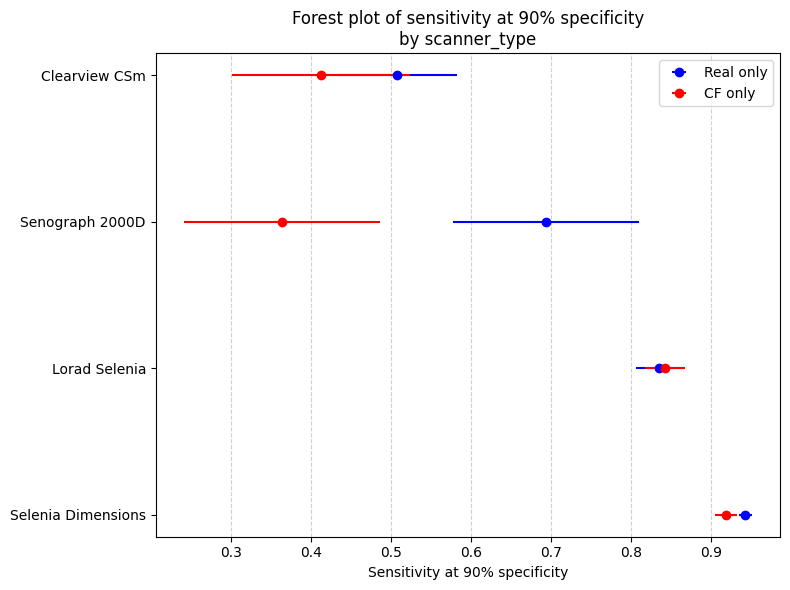

Found 27 model folders.

Found 9 real_only models.
Found 9 cf_only models.

Processing real_only model: final_models_2/real_only_resnet18_bs64_lr0.0001_epochs10/
Processing real_only model: final_models_2/real_only_resnet50_bs64_lr0.0001_epochs10/
Processing real_only model: final_models_2/real_only_resnet50_bs256_lr0.0005_epochs10/
Processing real_only model: final_models_2/real_only_resnet18_bs256_lr0.0005_epochs10/
Processing real_only model: final_models_2/real_only_resnet34_bs256_lr0.0005_epochs10/
Processing real_only model: final_models_2/real_only_resnet34_bs64_lr0.0001_epochs10/
Processing real_only model: final_models_2/real_only_resnet34_bs128_lr0.0003_epochs10/
Processing real_only model: final_models_2/real_only_resnet18_bs128_lr0.0003_epochs10/
Processing real_only model: final_models_2/real_only_resnet50_bs128_lr0.0003_epochs10/
Processing cf_only model: final_models_2/cf_only_resnet34_bs128_lr0.0003_epochs10/
Processing cf_only model: final_models_2/cf_only_resnet18_bs1

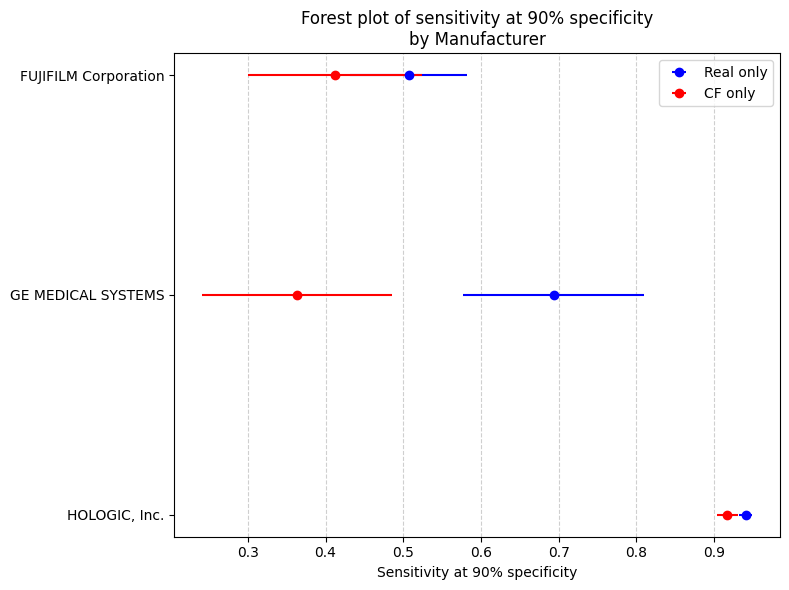

In [14]:
attributes = ['scanner_type', 'Manufacturer']

# TODO just realised this is a rlly inefficient way to do this...

for attribute in attributes:
    comparison_df = run_subgroup_mann_whitney_u_across_models('final_models_2/', attribute=attribute)
    plot_forest_comparison(comparison_df, attribute)

In [13]:
def plot_forest_comparison(comparison_df, attribute, figsize=(8, 6)):
    """
    Plot forest plot comparing real_only vs cf_and_real models.
    
    Parameters:
    - comparison_df: output from run_subgroup_analysis_across_models
    - attribute: name of the attribute (e.g. 'age_group', 'race')
    - figsize: size of the plot
    """
    # Sort by real_only mean sensitivity for nicer plotting
    comparison_df = comparison_df.sort_values(by='mean_real', ascending=False).reset_index(drop=True)
    
    # Y positions
    y_pos = np.arange(len(comparison_df))
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Plot real_only
    plt.errorbar(
        comparison_df['mean_real'], y_pos,
        xerr=comparison_df['std_real'],
        fmt='o', color='blue', label='Real only'
    )
    
    # Plot cf_and_real
    plt.errorbar(
        comparison_df['mean_cf_and_real'], y_pos,
        xerr=comparison_df['std_cf_and_real'],
        fmt='o', color='red', label='CF only'
    )
    
    # Y labels = attribute values
    plt.yticks(y_pos, comparison_df[attribute])
    plt.xlabel('Sensitivity at 90% specificity')
    plt.title(f'Forest plot of sensitivity at 90% specificity\nby {attribute}')
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


Found 27 model folders.

Found 9 real_only models.
Found 9 cf_and_real models.

Processing real_only model: final_models_2/real_only_resnet18_bs64_lr0.0001_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.791418       1262            0
      A                     NaN       NaN       NaN   0.750918        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing real_only model: final_models_2/real_only_resnet50_bs64_lr0.0001_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.988062       1262            0
      A                     NaN       NaN       NaN   0.623320        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing real_only model: final_models_2/real_only_resnet50_bs256_lr0.0005_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.998411       1262            0
      A                     NaN       NaN       NaN   0.819749        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing real_only model: final_models_2/real_only_resnet18_bs256_lr0.0005_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.169131       1262            0
      A                     NaN       NaN       NaN   0.007801        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing real_only model: final_models_2/real_only_resnet34_bs256_lr0.0005_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.925701       1262            0
      A                     NaN       NaN       NaN   0.819207        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing real_only model: final_models_2/real_only_resnet34_bs64_lr0.0001_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.991348       1262            0
      A                     NaN       NaN       NaN   0.803006        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing real_only model: final_models_2/real_only_resnet34_bs128_lr0.0003_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.947113       1262            0
      A                     NaN       NaN       NaN   0.887522        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing real_only model: final_models_2/real_only_resnet18_bs128_lr0.0003_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.228845       1262            0
      A                     NaN       NaN       NaN   0.015145        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing real_only model: final_models_2/real_only_resnet50_bs128_lr0.0003_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.992319       1262            0
      A                     NaN       NaN       NaN   0.461942        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing cf_and_real model: final_models_2/cf_and_real_resnet18_bs64_lr0.0001_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.998276       1262            0
      A                     NaN       NaN       NaN   0.060197        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing cf_and_real model: final_models_2/cf_and_real_resnet18_bs128_lr0.0003_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.997434       1262            0
      A                     NaN       NaN       NaN   0.747938        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing cf_and_real model: final_models_2/cf_and_real_resnet34_bs64_lr0.0001_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.995558       1262            0
      A                     NaN       NaN       NaN   0.048047        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing cf_and_real model: final_models_2/cf_and_real_resnet50_bs128_lr0.0003_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.660282       1262            0
      A                     NaN       NaN       NaN   0.121217        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing cf_and_real model: final_models_2/cf_and_real_resnet50_bs64_lr0.0001_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.999975       1262            0
      A                     NaN       NaN       NaN   0.478300        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing cf_and_real model: final_models_2/cf_and_real_resnet34_bs128_lr0.0003_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.994146       1262            0
      A                     NaN       NaN       NaN   0.747627        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing cf_and_real model: final_models_2/cf_and_real_resnet34_bs256_lr0.0005_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.548915       1262            0
      A                     NaN       NaN       NaN   0.032744        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing cf_and_real model: final_models_2/cf_and_real_resnet50_bs256_lr0.0005_epochs10/


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(



=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.998190       1262            0
      A                     NaN       NaN       NaN   0.390185        350            0
      D                     NaN       NaN       NaN        NaN        139          139
Processing cf_and_real model: final_models_2/cf_and_real_resnet18_bs256_lr0.0005_epochs10/

=== Subgroup analysis for density ===
density  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
      C                     NaN       NaN       NaN        NaN       1150         1150
      B                     NaN       NaN       NaN   0.922692       1262            0
      A                     NaN       NaN       NaN   0.533701        350            0
      D                     NaN       NaN       

/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


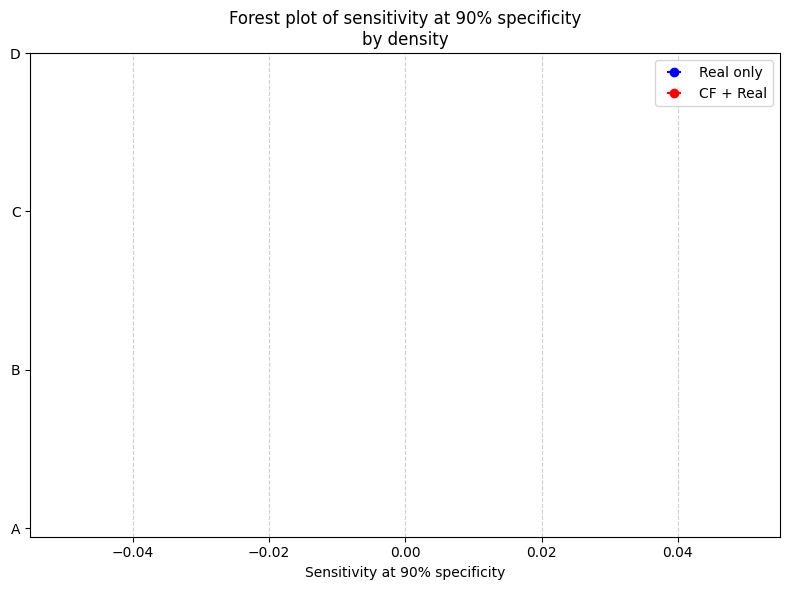

In [11]:
# attributes = ['scanner_type', 'age_group', 'Manufacturer', 'race']
attributes = ['density']

for attribute in attributes:
    comparison_df = run_subgroup_analysis_across_models('final_models_2/', attribute=attribute)
    plot_forest_comparison(comparison_df, attribute=attribute)

In [32]:
def plot_forest(results_df, attribute_name, sort=True):
    df_plot = results_df.copy()
    
    # Optionally sort by sensitivity
    if sort:
        df_plot = df_plot.sort_values(by='sensitivity_at_90_spec')
    
    y_pos = range(len(df_plot))
    
    fig, ax = plt.subplots(figsize=(8, 0.5 * len(df_plot) + 2))
    
    ax.errorbar(
        df_plot['sensitivity_at_90_spec'], y_pos,
        xerr=[df_plot['sensitivity_at_90_spec'] - df_plot['ci_lower'], 
              df_plot['ci_upper'] - df_plot['sensitivity_at_90_spec']],
        fmt='o', color='black', ecolor='blue', capsize=5, markersize=5
    )
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_plot[attribute_name])
    ax.set_xlabel('Sensitivity at 90% specificity')
    ax.set_title(f'Forest plot of sensitivity per {attribute_name}')
    
    # Grid and layout
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    plt.show()


=== Subgroup analysis for Manufacturer ===
        Manufacturer  sensitivity_at_90_spec  ci_lower  ci_upper  threshold  n_samples  n_positives
       HOLOGIC, Inc.                0.944352  0.931403  0.957301   0.322206       2724         1204
FUJIFILM Corporation                0.375000  0.238043  0.511957   0.960915         85           48
  GE MEDICAL SYSTEMS                0.432432  0.272802  0.592063   0.966945         92           37


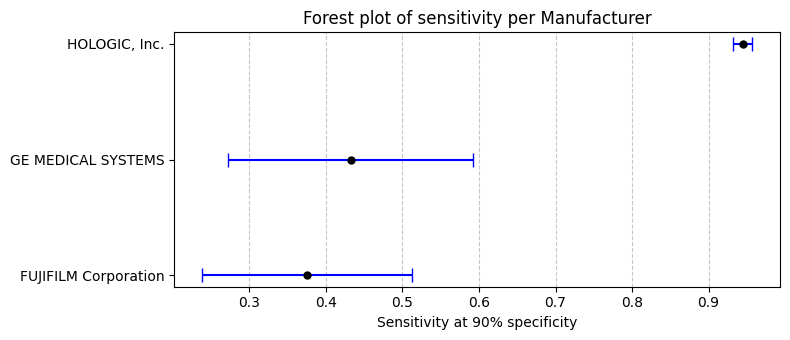

In [46]:
df = get_subgroup_sensitivities_at_fixed_specificity(cf_and_real_model_path, 'Manufacturer', 0.9)
plot_forest(df, 'Manufacturer')


In [19]:
# def sensitivity_at_fixed_specificity(y_true, y_prob, target_specificity):
#     fpr, tpr, thresholds = roc_curve(y_true, y_prob)
#     specificity = 1 - fpr
    
#     # Find the closest specificity >= target_specificity
#     idx = np.where(specificity >= target_specificity)[0][-1]
    
#     sensitivity = tpr[idx]
#     threshold = thresholds[idx]
    
#     return sensitivity, threshold

def sensitivity_at_fixed_specificity(y_true, y_prob, target_specificity=0.9):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    specificity = 1 - fpr
    
    # Find thresholds where specificity >= target_specificity
    valid_idxs = np.where(specificity >= target_specificity)[0]
    
    if len(valid_idxs) == 0:
        # No threshold satisfies the target specificity — return None or np.nan
        return np.nan, np.nan
    
    # Pick threshold with highest sensitivity (can also pick closest to 90% specificity if you want)
    idx = valid_idxs[-1]  # last index where specificity >= target_specificity
    
    sensitivity = tpr[idx]
    threshold = thresholds[idx]
    
    return sensitivity, threshold

def get_subgroup_sensitivities_at_fixed_specificity(model_path):
    df = get_embed_df()
    df_prd, df_emb = get_df_prd_emb(model_path)
    df = get_df_combined(df, df_prd, df_emb)
    
    attributes = ['ManufacturerModelName']
    # attributes = ['ManufacturerModelName', 'race', 'density', 'age_group']

    # attributes = ['Manufacturer', 'ManufacturerModelName', 'FinalImageType', 'ViewPosition', 
    #             'ImageLateralityFinal', 'race', 'is_positive', 'density', 'class_0', 'class_1', 'correct']

    results = []
    
    for attribute in attributes:
        for a in df[attribute].unique():
            subgroup = df[df[attribute] == a]
            
            y_true = subgroup['target'].values
            y_score = subgroup['class_1'].values
            
            sensitivity, threshold = sensitivity_at_fixed_specificity(y_true, y_score, target_specificity=0.9)
            
            results.append({
                attribute: a,
                'sensitivity_at_90_spec': sensitivity,
                'threshold': threshold,
                'n_samples': len(subgroup)
            })
            
        results_df = pd.DataFrame(results)
        
        print(results_df.to_string(index=False))

    

In [20]:
get_subgroup_sensitivities_at_fixed_specificity(real_model_path)

get_subgroup_sensitivities_at_fixed_specificity(cf_and_real_model_path)

(398458, 57)


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


     ManufacturerModelName  sensitivity_at_90_spec  threshold  n_samples
        Selenia Dimensions                0.980426   0.203391       2640
             Clearview CSm                0.895833   0.177312         85
Senograph 2000D ADS_17.4.5                0.783784   0.864711         86
             Lorad Selenia                0.931034   0.230140         84
  Senograph 2000D ADS_17.5                     NaN   0.089853          6
(398458, 57)
     ManufacturerModelName  sensitivity_at_90_spec  threshold  n_samples
        Selenia Dimensions                0.987234   0.140985       2640
             Clearview CSm                0.875000   0.445454         85
Senograph 2000D ADS_17.4.5                0.459459   0.898411         86
             Lorad Selenia                0.896552   0.259591         84
  Senograph 2000D ADS_17.5                     NaN   0.111725          6


/vol/biomedic3/bglocker/ugproj/vg521/counterfactuals/cf-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


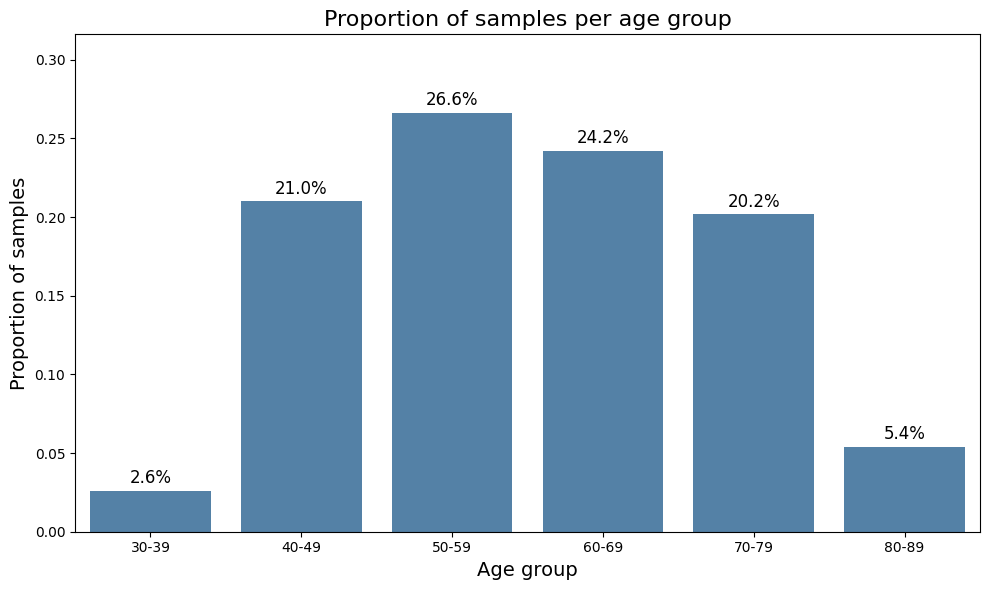

In [31]:
def get_age_group_distribution():
    age_counts = df['age_group'].value_counts(sort=False)

    # Compute proportion
    age_proportions = age_counts / age_counts.sum()

    # Create a DataFrame for plotting
    age_distribution_df = pd.DataFrame({
        'age_group': age_counts.index,
        'count': age_counts.values,
        'proportion': age_proportions.values
    })

    plt.figure(figsize=(10, 6))
    sns.barplot(data=age_distribution_df, x='age_group', y='proportion', order=labels, color='steelblue')

    # Add percentage labels on top of bars
    for i, row in age_distribution_df.iterrows():
        plt.text(i, row['proportion'] + 0.005, f"{row['proportion']*100:.1f}%", ha='center', fontsize=12)

    plt.title('Proportion of samples per age group', fontsize=16)
    plt.ylabel('Proportion of samples', fontsize=14)
    plt.xlabel('Age group', fontsize=14)
    plt.ylim(0, age_distribution_df['proportion'].max() + 0.05)  # leave space for labels

    plt.tight_layout()
    plt.show()
    
get_age_group_distribution()

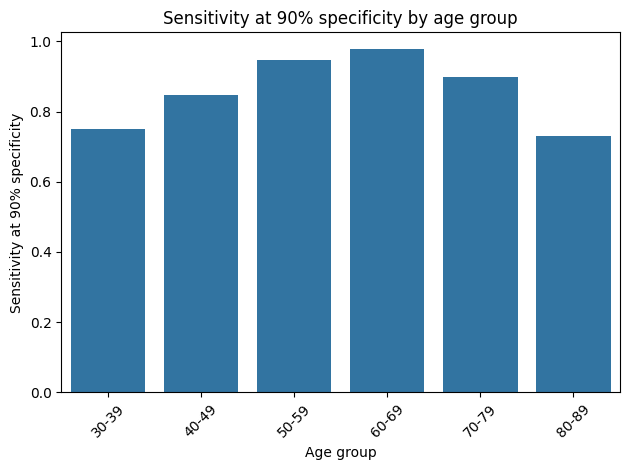

In [34]:
results_df['age_group'] = pd.Categorical(results_df['age_group'], categories=labels, ordered=True)


sns.barplot(data=results_df, x='age_group', y='sensitivity_at_90_spec')
plt.title('Sensitivity at 90% specificity by age group')
plt.ylabel('Sensitivity at 90% specificity')
plt.xlabel('Age group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
modelname_map = {
    "Selenia Dimensions": "Hologic Selenia",
    "Lorad Selenia": "Hologic Selenia",
    "Senographe Essential VERSION ADS_53.40": "Senographe Essential",
    "Senographe Essential VERSION ADS_54.10": "Senographe Essential",
    "Senograph 2000D ADS_17.4.5": "Senographe 2000D",
    "Senograph 2000D ADS_17.5": "Senographe 2000D",
    "Clearview CSm": "Siemens Clearview",
    "Senographe Pristina": "Senographe Pristina",
}

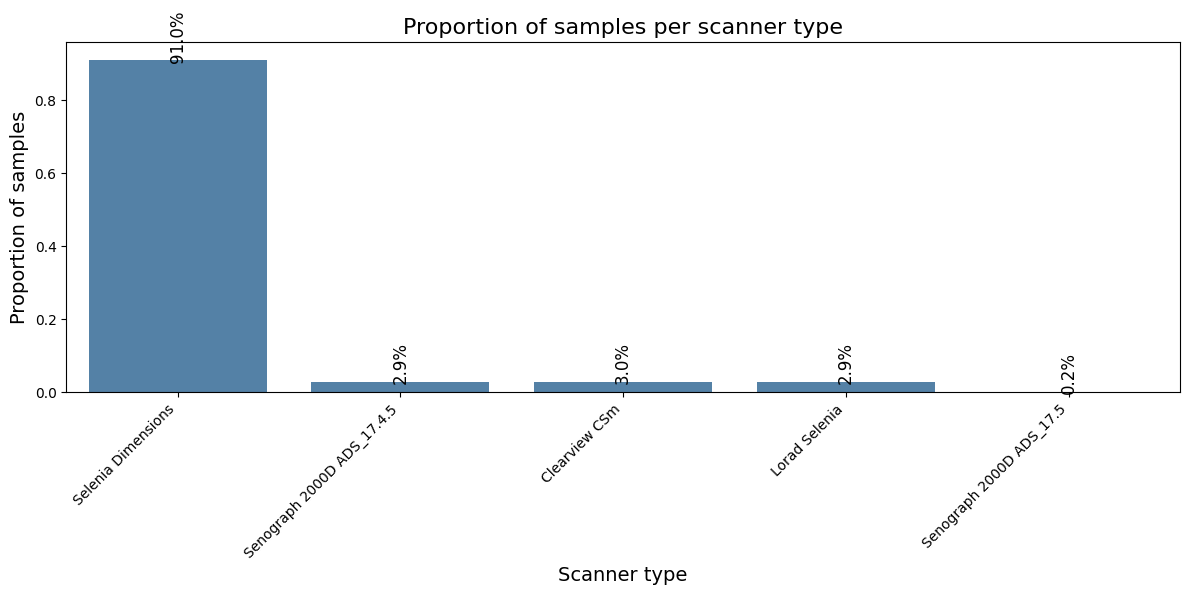

In [43]:
scanner_counts = df['ManufacturerModelName'].value_counts(sort=False)
scanner_proportions = scanner_counts / scanner_counts.sum()

scanner_distribution_df = pd.DataFrame({
    'scanner_group': scanner_counts.index,
    'count': scanner_counts.values,
    'proportion': scanner_proportions.values
})

scanner_distribution_df = scanner_distribution_df.sort_values('proportion', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=scanner_distribution_df, x='scanner_group', y='proportion', color='steelblue')

# Add percentage labels on top of bars
for i, row in scanner_distribution_df.iterrows():
    plt.text(i, row['proportion'] + 0.005, f"{row['proportion']*100:.1f}%", ha='center', fontsize=12, rotation=90)

# Labels
plt.title('Proportion of samples per scanner type', fontsize=16)
plt.ylabel('Proportion of samples', fontsize=14)
plt.xlabel('Scanner type', fontsize=14)

# Adjust Y limit for label space
plt.ylim(0, scanner_distribution_df['proportion'].max() + 0.05)

# Rotate X axis labels for readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()